In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
from keras import layers
from sklearn.svm import SVC
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import ResNet50V2
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
# Dataset Folder
dataset_path = "/kaggle/input/orange-diseases-dataset/dataset/train"

categories = os.listdir(dataset_path)
labels = [i for i in range(len(categories))]

label_dict = dict(zip(categories, labels))

print(label_dict)
print(categories)
print(labels)

{'grenning': 0, 'canker': 1, 'blackspot': 2, 'fresh': 3}
['grenning', 'canker', 'blackspot', 'fresh']
[0, 1, 2, 3]


In [4]:
classes = ['grenning', 'canker', 'blackspot', 'fresh']

# Fungsi untuk load dataset
def load_dataset(dataset_path):
    # Inisialisasi array data dan label
    data = []
    labels = []

    # Loop pada setiap subdirektori (kelas) dan file gambar di dalamnya
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            # Filter hanya file gambar dengan ekstensi .png atau .jpg
            if file.endswith(".png") or file.endswith(".jpg"):
                # Ambil path file gambar
                image_path = os.path.join(root, file)

                # Ambil label kelas dari nama subfolder
                label = os.path.basename(root)

                # Cek apakah label kelas termasuk dalam daftar classes
                if label in classes:
                    # Load gambar menggunakan fungsi preprocess_image
                    image = preprocess_image(image_path)

                    # Simpan gambar dan label ke dalam array
                    data.append(image)
                    labels.append(classes.index(label))

    # Konversi array data dan label ke dalam format numpy
    data = np.array(data, dtype="float32")
    labels = np.array(labels)

    return data, labels

In [5]:
IMG_HEIGHT = 224
IMG_WIDTH = 224

def preprocess_image(image_path):
    # Load gambar
    image = cv2.imread(image_path)

    # Resize gambar ke ukuran yang diinginkan
    image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    
    # Ubah citra warna ke skema warna RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Normalisasi warna
    image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    return image

# Load dataset
data, labels = load_dataset(dataset_path)

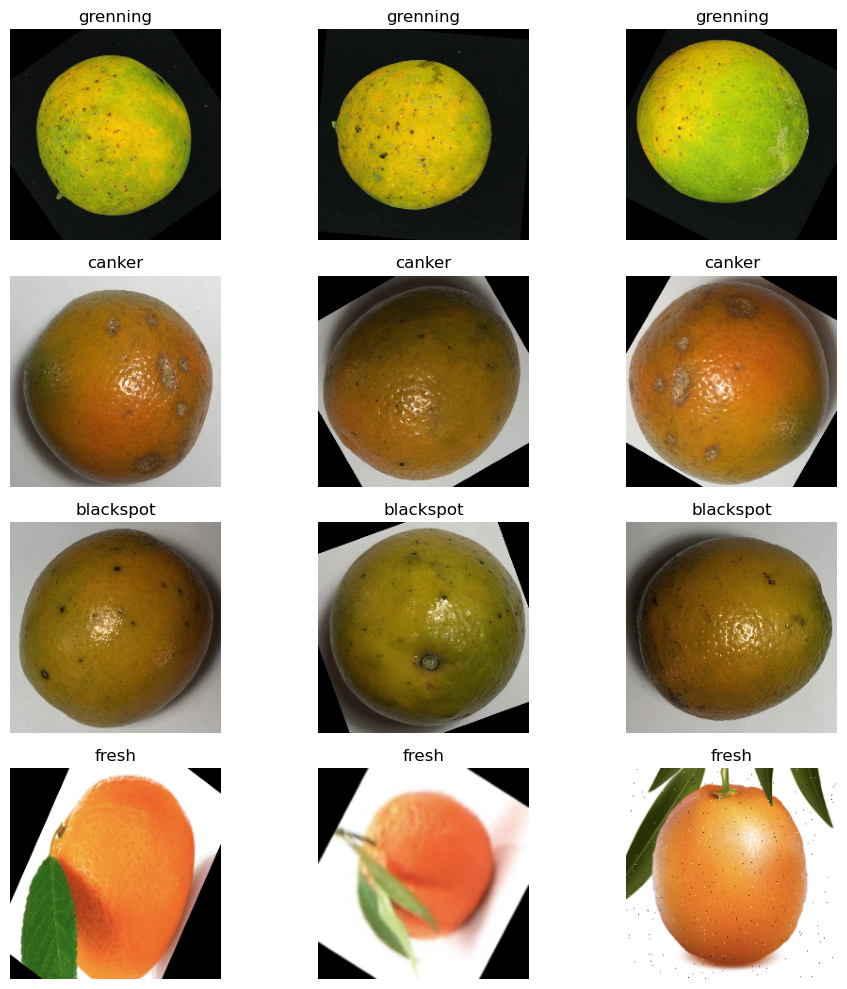

In [6]:
# Mengambil 12 data dan label pertama dari setiap kelas
data_samples = []
labels_samples = []
num_samples_per_class = 3

for class_index in range(len(classes)):
    class_data = data[labels == class_index][:num_samples_per_class]
    class_labels = labels[labels == class_index][:num_samples_per_class]
    data_samples.extend(class_data)
    labels_samples.extend(class_labels)

# Membuat grid sesuai dengan jumlah kelas
fig, axes = plt.subplots(len(classes), num_samples_per_class, figsize=(10, 10))

# Loop untuk setiap kelas dan sampel
for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        # Menampilkan gambar
        image = data_samples[i * num_samples_per_class + j]
        ax.imshow(image, cmap='gray')
        ax.axis('off')
        # Menampilkan label
        ax.set_title(classes[labels_samples[i * num_samples_per_class + j]])

# Menampilkan plot
plt.tight_layout()
plt.show()

In [7]:
# Mengubah data dan label menjadi array numpy
data = np.array(data)
labels = np.array(labels)

In [8]:
# Membagi data menjadi set pelatihan, validasi, dan pengujian
X_train, X_test_val, y_train, y_test_val = train_test_split(data, labels, test_size=0.2, random_state=32)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=32)

# Menambahkan dimensi tambahan pada data
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

print("Jumlah data pelatihan:", len(X_train))
print("Jumlah data validasi:", len(X_val))
print("Jumlah data pengujian:", len(X_test))

Jumlah data pelatihan: 931
Jumlah data validasi: 117
Jumlah data pengujian: 116


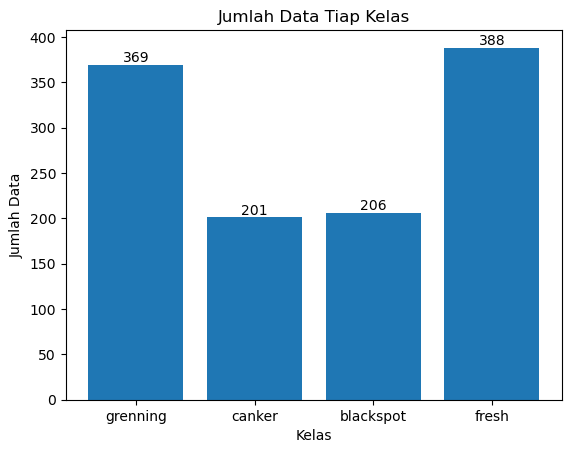

In [9]:
# Menghitung jumlah data untuk setiap kelas
class_count = [np.sum(labels == i) for i in range(len(classes))]

# Membuat diagram batang
plt.bar(classes, class_count)

# Menambahkan label pada sumbu x dan y
plt.xlabel('Kelas')
plt.ylabel('Jumlah Data')

# Menambahkan judul diagram
plt.title('Jumlah Data Tiap Kelas')

# Menampilkan angka jumlah data pada setiap batang
for i, count in enumerate(class_count):
    plt.text(i, count, str(count), ha='center', va='bottom')

# Menampilkan diagram batang
plt.show()

In [10]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))

base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
model.add(base_model)

model.add(tf.keras.layers.GlobalAveragePooling2D())

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation="relu"))
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dense(4, activation="softmax"))

checkpoint = tf.keras.callbacks.ModelCheckpoint('/kaggle/working/best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

model.summary()

94668760/94668760 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 64)                82

In [11]:
# Melatih model dengan menggunakan data pelatihan dan validasi
history = model.fit(X_train, y_train, batch_size=64, epochs=100, validation_data=(X_val, y_val), callbacks=[checkpoint])

Epoch 1/100
15/15 [==============================] - ETA: 0s - loss: 0.3262 - accuracy: 0.8711
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to /kaggle/working/best_model.h5
15/15 [==============================] - 61s 1s/step - loss: 0.3262 - accuracy: 0.8711 - val_loss: 103.0574 - val_accuracy: 0.3333
Epoch 2/100
15/15 [==============================] - ETA: 0s - loss: 0.1804 - accuracy: 0.9441
Epoch 2: val_accuracy did not improve from 0.33333
15/15 [==============================] - 8s 555ms/step - loss: 0.1804 - accuracy: 0.9441 - val_loss: 445.7919 - val_accuracy: 0.2051
Epoch 3/100
15/15 [==============================] - ETA: 0s - loss: 0.1126 - accuracy: 0.9689
Epoch 3: val_accuracy did not improve from 0.33333
15/15 [==============================] - 9s 569ms/step - loss: 0.1126 - accuracy: 0.9689 - val_loss: 12.1753 - val_accuracy: 0.3333
Epoch 4/100
15/15 [==============================] - ETA: 0s - loss: 0.1699 - accuracy: 0.9431
Epoch 4: val_accuracy d

In [12]:
# Perform label encoding
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

In [13]:
get_ac = history.history['accuracy']
get_los = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

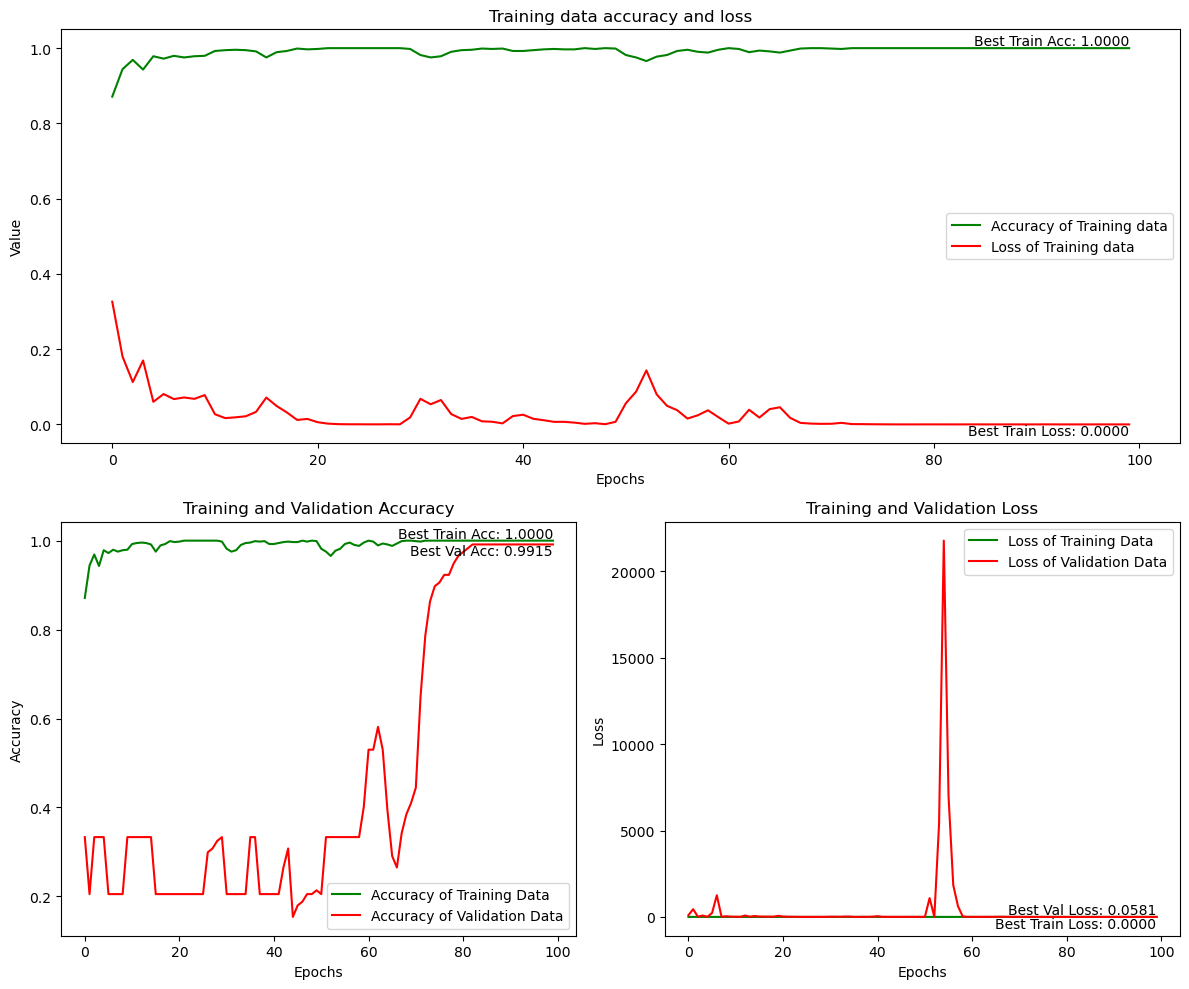

In [14]:
epochs = range(len(get_ac))

plt.figure(figsize=(12, 10))

# Plot Training Accuracy and Loss
plt.subplot(2, 1, 1)
plt.plot(epochs, get_ac, 'g', label='Accuracy of Training data')
plt.plot(epochs, get_los, 'r', label='Loss of Training data')
plt.title('Training data accuracy and loss')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.text(len(get_ac)-1, get_ac[-1], f'Best Train Acc: {max(get_ac):.4f}', ha='right', va='bottom')
plt.text(len(get_los)-1, get_los[-1], f'Best Train Loss: {min(get_los):.4f}', ha='right', va='top')

# Plot Training and Validation Accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, get_ac, 'g', label='Accuracy of Training Data')
plt.plot(epochs, val_acc, 'r', label='Accuracy of Validation Data')
plt.title('Training and Validation Accuracy')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.text(len(get_ac)-1, get_ac[-1], f'Best Train Acc: {max(get_ac):.4f}', ha='right', va='bottom')
plt.text(len(val_acc)-1, val_acc[-1], f'Best Val Acc: {max(val_acc):.4f}', ha='right', va='top')

# Plot Training and Validation Loss
plt.subplot(2, 2, 4)
plt.plot(epochs, get_los, 'g', label='Loss of Training Data')
plt.plot(epochs, val_loss, 'r', label='Loss of Validation Data')
plt.title('Training and Validation Loss')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.text(len(get_los)-1, get_los[-1], f'Best Train Loss: {min(get_los):.4f}', ha='right', va='top')
plt.text(len(val_loss)-1, val_loss[-1], f'Best Val Loss: {min(val_loss):.4f}', ha='right', va='bottom')

plt.tight_layout()
plt.show()

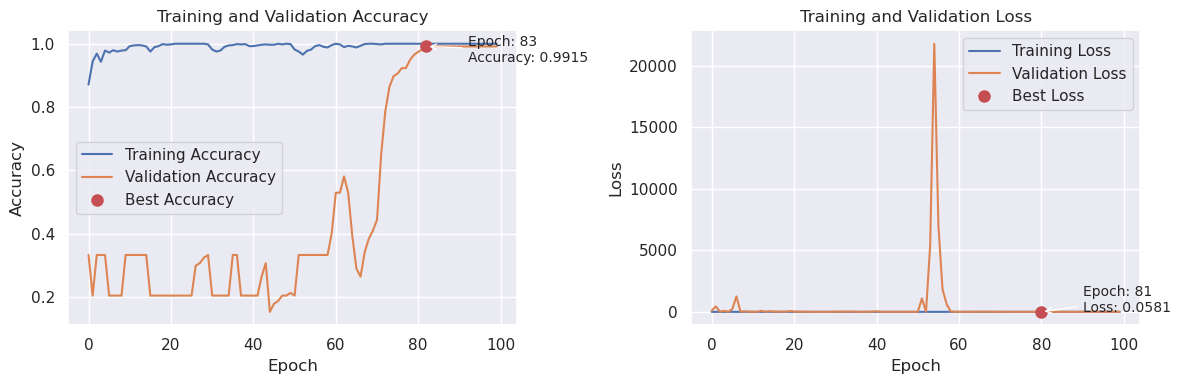

In [15]:
# Plot akurasi dan loss pada setiap epoch
sns.set()
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history.epoch, history.history['accuracy'], label='Training Accuracy')
axes[0].plot(history.epoch, history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Training and Validation Accuracy')
axes[0].legend()

axes[1].plot(history.epoch, history.history['loss'], label='Training Loss')
axes[1].plot(history.epoch, history.history['val_loss'], label='Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Training and Validation Loss')
axes[1].legend()

# Menandai posisi best accuracy dan best loss
best_accuracy_epoch = np.argmax(history.history['val_accuracy'])
best_accuracy = history.history['val_accuracy'][best_accuracy_epoch]
best_loss_epoch = np.argmin(history.history['val_loss'])
best_loss = history.history['val_loss'][best_loss_epoch]

axes[0].plot(best_accuracy_epoch, best_accuracy, 'ro', markersize=8, label='Best Accuracy')
axes[0].annotate(f'Epoch: {best_accuracy_epoch+1}\nAccuracy: {best_accuracy:.4f}',
                xy=(best_accuracy_epoch, best_accuracy),
                xytext=(best_accuracy_epoch+10, best_accuracy-0.05),
                arrowprops=dict(facecolor='red', arrowstyle='->'),
                fontsize=10)  # Ubah ukuran font disini
axes[0].legend()

axes[1].plot(best_loss_epoch, best_loss, 'ro', markersize=8, label='Best Loss')
axes[1].annotate(f'Epoch: {best_loss_epoch+1}\nLoss: {best_loss:.4f}',
                xy=(best_loss_epoch, best_loss),
                xytext=(best_loss_epoch+10, best_loss+0.1),
                arrowprops=dict(facecolor='red', arrowstyle='->'),
                fontsize=10)  # Ubah ukuran font disini
axes[1].legend()

plt.tight_layout()
plt.savefig('epoch_history_res5050.png')
plt.show()

In [16]:
# Evaluasi model menggunakan data pengujian
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Akurasi pada data pengujian:", test_acc)

4/4 [==============================] - 3s 404ms/step - loss: 0.0952 - accuracy: 0.9741
Akurasi pada data pengujian: 0.9741379022598267


In [17]:
# Evaluasi model pada data pengujian
y_test_pred = model.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

accuracy = accuracy_score(y_test_encoded, y_test_pred_classes)
precision = precision_score(y_test_encoded, y_test_pred_classes, average='macro')
recall = recall_score(y_test_encoded, y_test_pred_classes, average='macro')
f1 = f1_score(y_test_encoded, y_test_pred_classes, average='macro')

print("Akurasi Pengujian:", accuracy)
print("Presisi Pengujian:", precision)
print("Recall Pengujian:", recall)
print("F1 Score Pengujian:", f1)

4/4 [==============================] - 1s 83ms/step
Akurasi Pengujian: 0.9741379310344828
Presisi Pengujian: 0.9464285714285714
Recall Pengujian: 0.9605263157894737
F1 Score Pengujian: 0.9485714285714285


In [18]:
# Evaluasi model pada data pengujian setiap jenis penyakit
y_test_pred = model.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

accuracy = accuracy_score(y_test_encoded, y_test_pred_classes)

class_accuracy = {}
for i, category in enumerate(categories):
    class_accuracy[category] = accuracy_score(y_test_encoded[y_test_encoded == i], y_test_pred_classes[y_test_encoded == i])

print("Akurasi Pengujian: {:.2%}".format(accuracy))
print("Akurasi per Kelas:")
for category, acc in class_accuracy.items():
    print("- {}: {:.2%}".format(category, acc))

4/4 [==============================] - 0s 83ms/step
Akurasi Pengujian: 97.41%
Akurasi per Kelas:
- grenning: 100.00%
- canker: 84.21%
- blackspot: 100.00%
- fresh: 100.00%


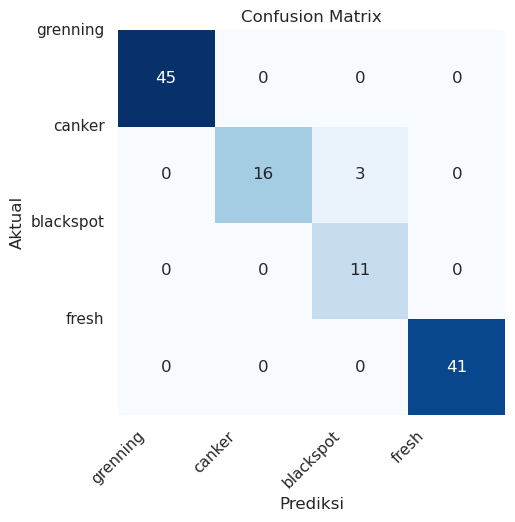

In [19]:
# Mengonversi label hasil prediksi menjadi nama label kelas
predicted_labels = label_encoder.inverse_transform(y_test_pred_classes)

# Mengonversi label sebenarnya menjadi nama label kelas
actual_labels = label_encoder.inverse_transform(y_test_encoded)

# Membuat confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)

# Menampilkan confusion matrix dalam bentuk heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.title("Confusion Matrix")
plt.xticks(ticks=np.arange(len(classes)), labels=classes, rotation=45)
plt.yticks(ticks=np.arange(len(classes)), labels=classes, rotation=0)
plt.show()

1/1 [==============================] - 0s 28ms/step


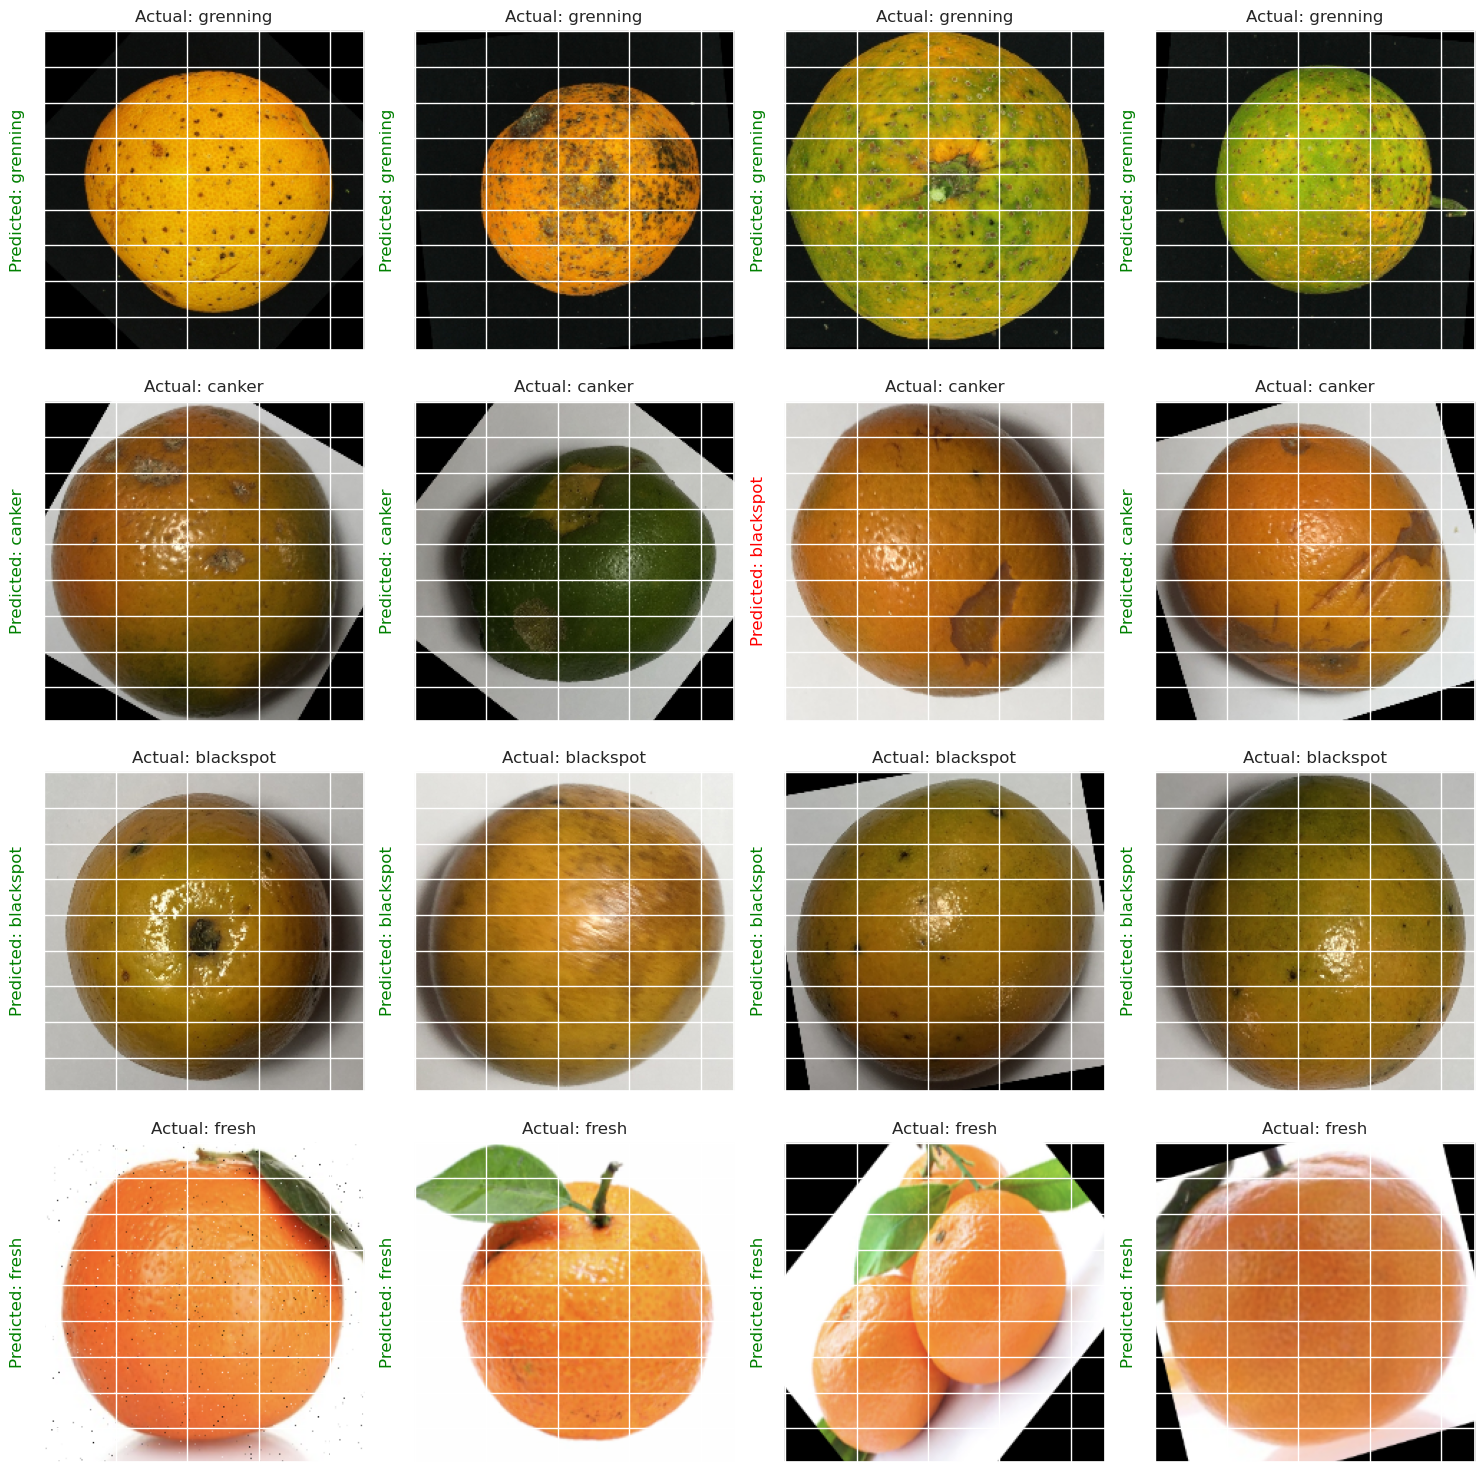

In [20]:
# Menampilkan 4 gambar dari setiap kelas secara bersamaan
plt.figure(figsize=(15, 15))
for i in range(len(classes)):
    class_images = X_test[y_test_encoded == i]
    random_images = random.sample(list(class_images), 4)
    for j, image in enumerate(random_images):
        ax = plt.subplot(len(classes), 4, i*4+j + 1)
        plt.imshow(image.squeeze(), cmap='gray')
        image = np.expand_dims(image, axis=0)
        predictions = model.predict(image)
        predicted_label = np.argmax(predictions[0])
        plt.title("Actual: " + classes[i])
        if i == predicted_label:
            plt.ylabel("Predicted: " + classes[predicted_label], color='green')
        else:
            plt.ylabel("Predicted: " + classes[predicted_label], color='red')
        plt.gca().axes.yaxis.set_ticklabels([])
        plt.gca().axes.xaxis.set_ticklabels([])
plt.tight_layout()
plt.show()